In [1]:
import numpy as np
import matplotlib.pyplot as plt

c = 299_800_000

In [2]:
def gaussian(x, center, FWHM):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    normalisation_coeffient = 1  #1 /(sigma *(2*np.pi)**0.5)
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    return normalisation_coeffient *np.exp(exponent)

In [3]:
array_length = 1000 #in pixels
pixel_pitch = 50 #in um
central_freq = 3 #in THz
FWHM_freq = 2 #in THz
theta = 60 #in arcminutes
noise_level = 0 #% of maximum amplitude
number_of_averages = 5 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [4]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /c #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /c # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


57.2604893728845


In [5]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = c *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
phase = [(-1)**n for n in range(len(wavenumbers))] #ensure that the interferogram is centered and has a positive central fringe
amplitudes = phase *gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = c *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_phase = [(-1)**n for n in range(len(oversampled_wn))] #ensure that the interferogram is centered and has a positive central fringe
oversampled_amps = oversampled_phase *gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber)

In [6]:
######## ADD NOISE IN FREQUENCY DOMAIN ############

amplitudes = np.tile(amplitudes, (number_of_averages, 1))

FWHM_noise = np.max(amplitudes) *noise_level/100
std = FWHM_noise *(8*np.log(2))**-0.5
noise = np.random.normal(0, std, amplitudes.shape) #(2, *amplitudes.shape))
#noise = noise[0] + 1j*noise[1]
#noise *=  std / np.std(np.abs(noise))

noisy_amps = amplitudes +noise

In [7]:
####### IFFT TO MAKE INTERFEROGRAMS ###########

intensity = np.fft.irfft(noisy_amps, norm= "forward", n= array_length, axis= 1)
intensity_averaged = np.mean(intensity, axis= 0)
intensity_uncertainty = np.std(intensity, axis= 0)

displacement = [n *pixel_pitch*1e-3 for n in range(array_length)]

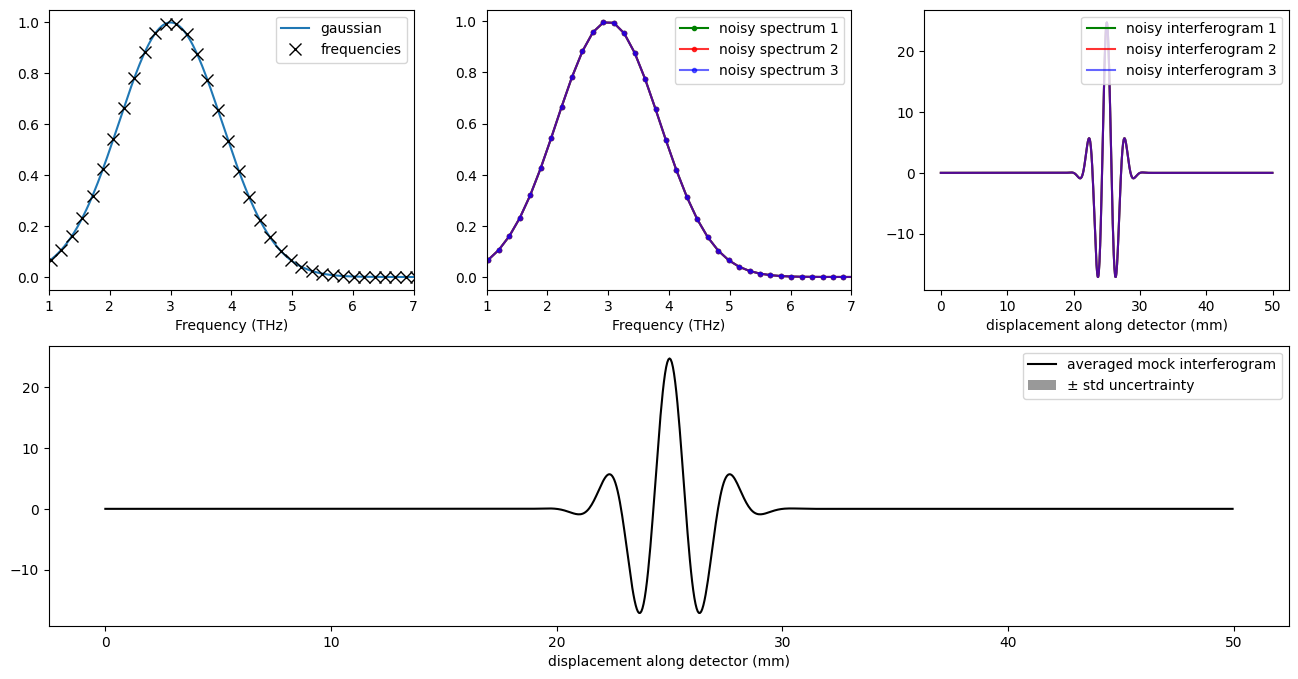

In [8]:
mosaic = [["spec", "noisy_spec", "noisy_amps"],
            ["amps", "amps", "amps"]]

fig, axs = plt.subplot_mosaic(mosaic, figsize=(16,8))

axs["spec"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec"].plot(freqs, np.abs(amplitudes[0]), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "frequencies")
axs["spec"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec"].legend(loc ="upper right")

axs["noisy_spec"].plot(freqs, np.abs(noisy_amps[0]), color= "green", alpha= 1, label= "noisy spectrum 1", marker= ".")
axs["noisy_spec"].plot(freqs, np.abs(noisy_amps[1]), color= "red", alpha= 0.8, label= "noisy spectrum 2", marker= ".")
axs["noisy_spec"].plot(freqs, np.abs(noisy_amps[2]), color= "blue", alpha= 0.6, label= "noisy spectrum 3", marker= ".")
axs["noisy_spec"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["noisy_spec"].legend(loc ="upper right")


axs["noisy_amps"].plot(displacement, intensity[0], color= "green", alpha= 1, label= "noisy interferogram 1")
axs["noisy_amps"].plot(displacement, intensity[1], color= "red", alpha= 0.8, label= "noisy interferogram 2")
axs["noisy_amps"].plot(displacement, intensity[2], color= "blue", alpha= 0.6, label= "noisy interferogram 3")
axs["noisy_amps"].set(xlabel= "displacement along detector (mm)")
axs["noisy_amps"].legend(loc ="upper right")


axs["amps"].plot(displacement, intensity_averaged, color= "k", label= "averaged mock interferogram")
axs["amps"].set(xlabel= "displacement along detector (mm)")
axs["amps"].fill_between(displacement, intensity_averaged-intensity_uncertainty, intensity_averaged+intensity_uncertainty, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs["amps"].legend(loc ="upper right")

plt.show()

In [10]:
#to_save = np.array([intensity, uncertainty]).T

#np.savetxt("data\\1dmockanderrors2.csv", to_save, delimiter=",")